In [146]:
execfile(r'D:\measuring\analysis\scripts\setup_analysis.py')
import scipy.fftpack
%matplotlib inline

In [147]:
from analysis.lib.nv import detection
folder= tb.latest_data()
files = []
for file in os.listdir("{0}".format(folder)):                                   
        if file.endswith("PQ_single_click_ent_111no2_SIL2_phase_stab.hdf5"):
            files.append('{0}\{1}'.format(folder,file))
print files

dataset_name   = '/111no2_SIL2_phase_stab/adwindata/'

['d:\\measuring\\data\\20170307\\144756_PQ_single_click_ent_111no2_SIL2_phase_stab\\144756_PQ_single_click_ent_111no2_SIL2_phase_stab.hdf5']


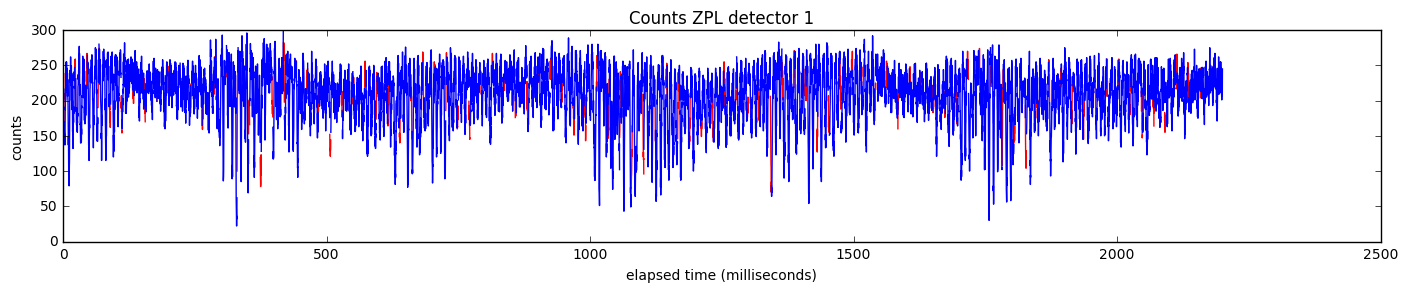

In [148]:
# stitch the different part and files together, make and save a plot of the data.
s = []
u_1 = []
v_1 = []

for i in files:
    f = h5py.File(i, "r")

    pid_counts_1 = f['{0}pid_counts'.format(dataset_name)]
    sample_counts_1 = f['{0}sampling_counts'.format(dataset_name)]
    max_repetitions = np.asarray(f['{0}completed_reps'.format(dataset_name)][...])
    
    delay = (f['/111no2_SIL2_phase_stab'].attrs.values()[48]/(f['/111no2_SIL2_phase_stab'].attrs.values()[23]*100))
    pid_cycles = f['/111no2_SIL2_phase_stab'].attrs.values()[269]
    sample_cycles = f['/111no2_SIL2_phase_stab'].attrs.values()[116]

    # stitch
    for i in xrange(max_repetitions):
        for j in xrange(pid_cycles):
#             s.append(setpoint)
             u_1.append(pid_counts_1[j+i*pid_cycles])
             v_1.append(None)

        for k in xrange(sample_cycles):
#            s.append(setpoint)
            u_1.append(None)
            v_1.append(sample_counts_1[k+i*sample_cycles])
    f.close()
      
t = np.arange(0, (len(v_1)*delay/10), (0.1*delay))


fig = plt.figure(figsize=(17,6))
ax = plt.subplot(211)
# plt.plot(t, s, 'y')
plt.plot(t, u_1, 'r')
plt.plot(t, v_1, 'b')
plt.title('Counts ZPL detector 1')
ax.set_xlabel('elapsed time (milliseconds)')
ax.set_ylabel('counts')


fig.savefig(os.path.join(folder, 'trace_counts.png'))

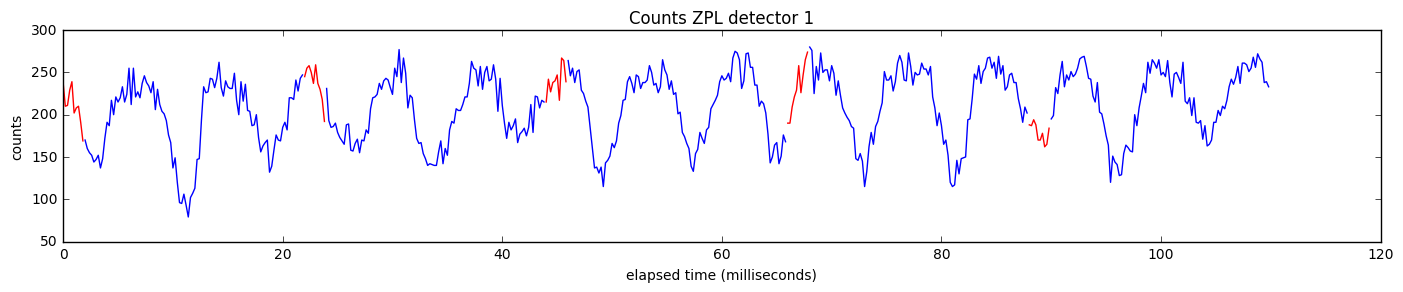

In [149]:
zoom = 5*(pid_cycles+sample_cycles)

fig = plt.figure(figsize=(17,6))
ax = plt.subplot(211)
# plt.plot(t[0:zoom], s[0:zoom], 'y')
plt.plot(t[0:zoom], u_1[0:zoom], 'r')
plt.plot(t[0:zoom], v_1[0:zoom], 'b')

plt.title('Counts ZPL detector 1')
ax.set_xlabel('elapsed time (milliseconds)')
ax.set_ylabel('counts')

fig.savefig(os.path.join(folder, 'trace_counts_zoomed.png'))

peak frequencies are:
[0.0, 150.0, 200.0, 750.0, 4250.0, 4800.0, 4850.0]


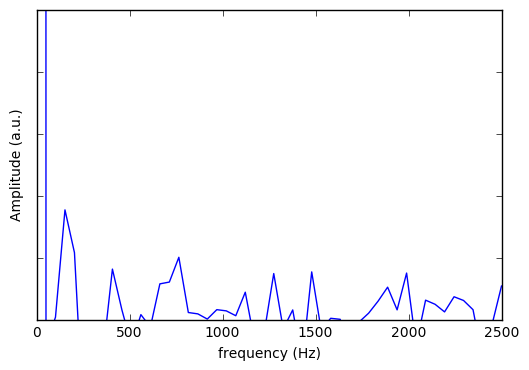

In [150]:
# fourier transform of the sample part
yf = [0]*sample_cycles
for j in files:
    f = h5py.File(j, "r")

    pid_counts_1 = f['{0}pid_counts'.format(dataset_name)]
    sample_counts_1 = f['{0}sampling_counts'.format(dataset_name)]
    max_repetitions = np.asarray(f['{0}completed_reps'.format(dataset_name)][...])
    
    delay = (f['/111no2_SIL2_phase_stab'].attrs.values()[48]/(f['/111no2_SIL2_phase_stab'].attrs.values()[23]*100))
    pid_cycles = f['/111no2_SIL2_phase_stab'].attrs.values()[269]
    sample_cycles = f['/111no2_SIL2_phase_stab'].attrs.values()[116]
 
    # stitch
    for i in xrange(max_repetitions):
        v_1 = []
        for k in xrange(sample_cycles):
            v_1.append(sample_counts_1[k+i*sample_cycles])
        yf = np.add(yf,scipy.fftpack.fft(v_1))

    f.close()

# sample spacing
xf = np.linspace(0, 1.0/(2.0*delay*10**-4), sample_cycles/2)

index_max = [i for i,v in enumerate(yf) if v > 2000]
frq_max = [x * (1.0/(delay*10**-4)) / sample_cycles for x in index_max]
print 'peak frequencies are:'
print frq_max

norm1 = yf / np.linalg.norm(yf)

fig, ax = plt.subplots()
plt.ylim([0,10000])
ax.plot(xf, yf[:len(yf)/2])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('Amplitude (a.u.)')
ax.set_yticklabels([])
fig.savefig(os.path.join(folder, 'fft.png'))